Copyright (c) 2018 [Geosoft Inc.](geosoft.com)

https://github.com/GeosoftInc/gxpy

[BSD 2-clause License](https://github.com/GeosoftInc/gxpy/blob/master/LICENSE)

# Working with grids and images

### Lessons
<!--- # Run this from a code cell to create TOC markdown: -->
<!--- import geosoft.gxpy.utility; print(geosoft.gxpy.utility.jupyter_markdown_toc('grids and images')) -->
 1. [What is a grid?](#What-is-a-grid?)
 2. [Imports, Geosoft context, get data from GitHub](#Imports,-Geosoft-context,-get-data-from-GitHub)
 3. [Convert a grid from one format to another](#Convert-a-grid-from-one-format-to-another)
 4. [Working with Grid instances](#Working-with-Grid-instances)
 5. [Displaying a grid](#Displaying-a-grid)
 6. [Grid Coordinate System](#Grid-Coordinate-System)
 7. [Display with coordinate systems](#Display-with-coordinate-systems)
 8. [Basic Grid Statistics](#Basic-Grid-Statistics)
 9. [Grid Iterator](#Grid-Iterator)

## What is a grid?

A grid is a form of spatial data that represents information (such as a gravity intensity, a magnetic reading, or a colour) at points organized as a 2-dimensional array on a right-handed cartesian plane:

<img src="https://github.com/GeosoftInc/gxpy/raw/9.3/examples/tutorial/Grids%20and%20Images/image2017-6-14_13-9-19.png" alt="Drawing" style="width: 500px;"/>

The plane on which the grid is located can be oriented in three dimensions relative to a Coordinate System on the Earth.  The most common grids are located on a horizontal surface relative to the Coordinate System.  For example, common surfaces might be sea-level, or the ground surface, or a constant elevation above or below the ground surface, or a constant elevation. Vertical cross-sections through the Earth are oriented to be orthogonal to the surface of the Earth.

A common term used with grids is the concept of a 'grid cell'.  In Geosoft's usage, grids are an array of points at a point location, and a 'grid cell' is the rectangular area that extends half-way to the neighboring grid points.

Spatial reference angles throughout the _geosoft.gxpy_ module will consistently use an angle in degrees azimuth, which is a clockwise-positive angle relative to a coordinate system frame (North, or positive Y). The _geosoft.gxapi.GXIMG_ class specifies the rotation angle in degrees counterclockwise-positive, and other references within the geosoft.gxapi may differ.

Grids are stored as files on the file system, and there are many common grid file formats in existence. When working with grid files in GX Developer you define the grid file format with the use of a decorator string appended to the grid file name. Geosoft supports the 11 formats (and their many derivatives) described in the Grid File Name Decorations section of the GX Developer documentation.  For example:

| grid file string | grid file type |
|:----------------:|:-------------- |
| 'c:/project/mag.grd(GRD)'	| Geosoft format grid. |
| 'c:/project/mag.tif(TIF)'	| GeoTIF |
| 'c:/project/image.jpg(IMG;T=5)' | jpeg image file
| 'c:/project/mag.grd(GRD;TYPE=COLOR)' | Geosoft colour grid |

__See also:__ [Tutorial Page](https://geosoftgxdev.atlassian.net/wiki/spaces/GXD93/pages/103415893/Grids+and+Images)

## Imports, Geosoft context, get data from GitHub

In [1]:
import geosoft.gxpy.gx as gx
import geosoft.gxpy.grid as gxgrid
import geosoft.gxpy.utility as gxu
from IPython.display import Image

gxc = gx.GXpy()

url = 'https://github.com/GeosoftInc/gxpy/raw/9.3/examples/tutorial/Grids%20and%20Images/'
gxu.url_retrieve(url + 'elevation_surfer.GRD')

'elevation_surfer.GRD'

## Convert a grid from one format to another

We will start with a common simple task, converting a grid from one format to another. Geosoft supports many common geospatial grid formats which can all be openned as a `geosoft.gxpy.grid.Grid` instance.  Different formats and characteristics are specified using *grid decorations*, which are appended to the grid file name.  See [Grid File Name Decorations](https://geosoftgxdev.atlassian.net/wiki/spaces/GXD93/pages/78184633/Grid+File+Name+Decorations) for all supported grid and image types and how to decorate the grid file name.

__Problem:__ You have a grid in a Geosoft-supported format, and you need the grid in some other format to use in a different application.

__Grid:__ `elevation_surfer.grd`, which is a Surfer v7 format grid file.

__Approach:__

1. Open the surfer grid with decoration `(SRF;VER=V7)`.
2. Use the `gxgrid.Grid.copy` class method to create an ER Mapper grid, which will have decoration `(ERM)`.

In [2]:
# open surfer grid
with gxgrid.Grid.open('elevation_surfer.grd(SRF;VER=V7)') as grid_surfer:

    # copy the grid to an ER Mapper format grid file
    with gxgrid.Grid.copy(grid_surfer, 'elevation.ers(ERM)', overwrite=True) as grid_erm:
        print('file:', grid_erm.file_name, 
              '\ndecorated:', grid_erm.file_name_decorated)

file: C:\Users\Ian\jupyter_notebooks\gxpy_tutorial\elevation.ers 
decorated: C:\Users\Ian\jupyter_notebooks\gxpy_tutorial\elevation.ers(ERM)


## Working with Grid instances

You work with a grid using a `geosoft.gxpy.grid.Grid` instance, which is a spatial dataset sub-class of a `geosoft.gxpy.geometry.Geometry`. In Geosoft, all spatial objects are sub-classed from the `Geometry` class, and all `Geometry` instances have a coordinate system and spatial extents. Other spatial datasets include Geosoft databases (`gdb` files), voxels (`geosoft_voxel` files), surfaces (`geosoft_surface` files), 2d views, which are contained in Geosoft `map` files, and 3d views which can be contained in a Geosoft `map` file or a `geosoft_3dv` file.

Dataset instances will usually be associated with a file on your computer and, like Python files, you should open and work with datasets using the python *`with`* statement, which ensures that the instance and associated resources are freed after the *`with`* statement looses context.

For example, the following shows two identical ways work with a grid instance, though the *`with`* is prefered:

In [3]:
# open surfer grid, then set to None to free resources
grid_surfer = gxgrid.Grid.open('elevation_surfer.grd(SRF;VER=V7)')
print(grid_surfer.name)
grid_surfer = None

# open surfer grid using with
with gxgrid.Grid.open('elevation_surfer.grd(SRF;VER=V7)') as grid_surfer:
    print(grid_surfer.name)

elevation_surfer
elevation_surfer


## Displaying a grid

One often needs to see what a grid looks like, and this is accomplished by displaying the grid as an image in which the colours represent data ranges. A simple way to do this is to create a grid image file as a *`png`* file ising the *`image_file()`* method.

In this example we create a shaded image with default colouring, and we create a 500 pixel-wide image:

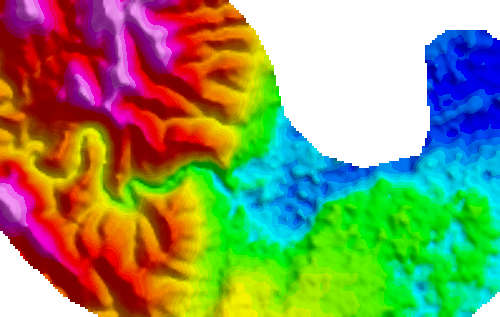

In [4]:
image_file = gxgrid.Grid.open('elevation_surfer.grd(SRF;VER=V7)').image_file(shade=True, pix_width=500)
Image(image_file)

A nicer image might include a neat-line outline, colour legend, scale bar and title. The *`gxgrid.figure_map()`* function will create a figure-style map, which can be saved to an image file using the *`image_file()`* method of the map instance.

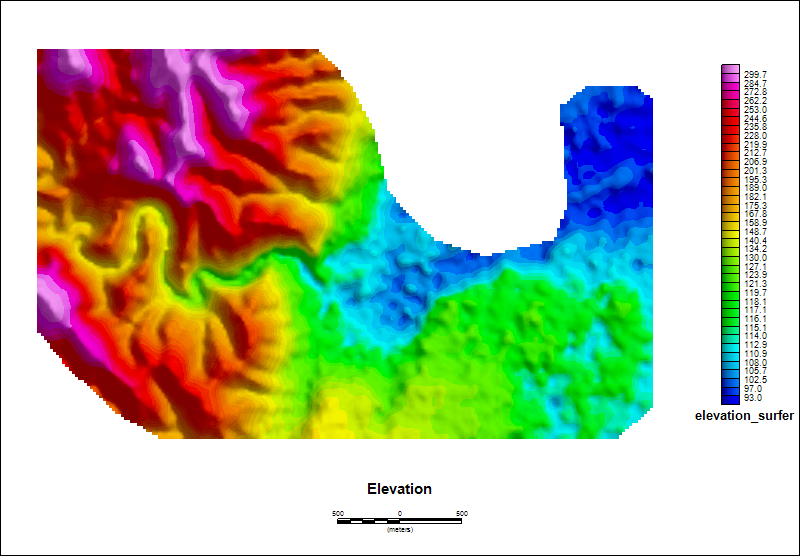

In [5]:
image_file = gxgrid.figure_map('elevation_surfer.grd(SRF;VER=V7)', title='Elevation').image_file(pix_width=800)    
Image(image_file)

## Grid Coordinate System

In Geosoft all spatial data should have a defined coordinate system which allows data to be located on the Earth.  This also takes advantage of Geosoft's ability to reproject data as required.  However, in this example the Surfer grid does not store the coordinate system information, but we know that the grid uses projection 'UTM zone 54S' on datum 'GDA94'.   Let's modify this script to set the coordinate system, which will be saved as part of the ER Mapper grid, which does have the ability to store  the coordinate system description.

In Geosoft, well-known coordinate systems like this can be described using the form 'GDA94 / UTM zone 54S', which conforms to the SEG Grid Exchange Format standard for describing coordinate systems.  You only need to set the coordinate_system property of the grid_surfer instance.

In [6]:
# define the coordinate system of the Surfer grid
with gxgrid.Grid.open('elevation_surfer.grd(SRF;VER=V7)') as grid_surfer: 
    grid_surfer.coordinate_system = 'GDA94 / UTM zone 54S'
 
    # copy the grid to an ER Mapper format grid file and the coordinate system is transferred
    with gxgrid.Grid.copy(grid_surfer, 'elevation.ers(ERM)', overwrite=True) as grid_erm:
        print(str(grid_erm.coordinate_system))

GDA94 / UTM zone 54S


Coordinate systems also contain the full coordinate system parameter information, from which you can construct coordinate systems in other applications.

In [7]:
with gxgrid.Grid.open('elevation.ers(ERM)') as grid_erm:
    print('Grid Exchange Format coordinate system:\n', grid_erm.coordinate_system.gxf)

Grid Exchange Format coordinate system:
 ['GDA94 / UTM zone 54S', 'GDA94,6378137,0.0818191910428158,0', '"Transverse Mercator",0,141,0.9996,500000,10000000', 'm,1', '"GDA94 to WGS 84 (1)",0,0,0,0,0,0,0']


In [8]:
with gxgrid.Grid.open('elevation.ers(ERM)') as grid_erm:
    print('ESRI WKT format:\n', grid_erm.coordinate_system.esri_wkt)

ESRI WKT format:
 PROJCS["UTM_zone_54S",GEOGCS["GCS_GDA_1994",DATUM["D_GDA_1994",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000],PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",141],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


In [9]:
with gxgrid.Grid.open('elevation.ers(ERM)') as grid_erm:
    print('JSON format:\n', grid_erm.coordinate_system.json)

JSON format:
 {"type": "Geosoft", "name": "GDA94 / UTM zone 54S", "datum": "GDA94,6378137,0.0818191910428158,0", "projection": "\"Transverse Mercator\",0,141,0.9996,500000,10000000", "units": "m,1", "local_datum": "\"GDA94 to WGS 84 (1)\",0,0,0,0,0,0,0", "orientation": "", "vcs": ""}


## Display with coordinate systems

The grids now have known coordinate systems and displaying the grid will show the coordinate system on the scale bar. We can also annotate geographic coordinates. This requires a Geosoft Desktop License.

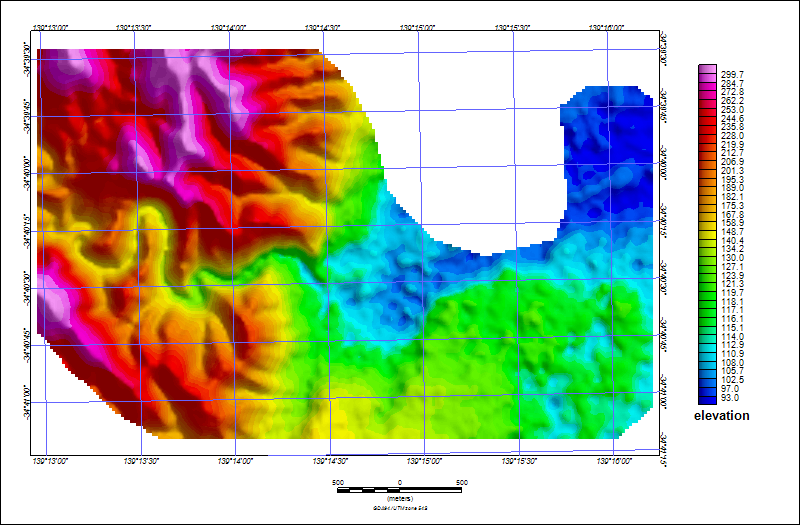

In [10]:
# show the grid as an image
Image(gxgrid.figure_map('elevation.ers(ERM)', features=('NEATLINE', 'SCALE', 'LEGEND', 'ANNOT_LL')).image_file(pix_width=800))

## Basic Grid Statistics

In this exercise we will work with the data stored in a grid.  One common need is to determine some basic statistical information about the grid data, such as the minimum, maximum, mean and standard deviation.  This exercise will work with the grid data a number of ways that demonstrate some useful patterns.

### Statistics using numpy

The smallest code and most efficient approach is to read the grid into a numpy array and then use the optimized numpy methods to determine statistics.  This has the benefit of speed and simplicity at the expense memory, which may be a concern for very large grids, though on modern 64-bit computers with most grids this would be the approach of choice. 

In [11]:
import numpy as np

# open the grid, using the with construct ensures resources are released
with gxgrid.Grid.open('elevation_surfer.grd(SRF;VER=V7)') as grid:
 
    # get the data in a numpy array
    data_values = grid.xyzv()[:, :, 3]
    
# print statistical properties
print('minimum: ', np.nanmin(data_values))
print('maximum: ', np.nanmax(data_values))
print('mean: ', np.nanmean(data_values))
print('standard deviation: ', np.nanstd(data_values))

minimum:  88.061668396
maximum:  339.345184326
mean:  167.952990336
standard deviation:  61.8165048181


### Statistics using Geosoft VVs

Many Geosoft methods will work with a _geosoft.gxpy.vv.GXvv_, which wraps the _geosoft.gxapi.GXVV_ class that deals with very long single-value vectors.  The Geosoft _GXVV_ methods works with Geosoft data types and, like numpy, is optimized to take advantage of multi-core processors to improve performance.  The pattern in this exercise reads a grid one grid row at a time, returning a _GXvv_  instance and accumulate statistics in an instance of the [_geosoft.gxapi.GXST_](http://localhost:63342/gxpy/docs/_build/html/GXST.html) class.

In [12]:
import geosoft.gxapi as gxapi

# the GXST class requires a desktop license
if gxc.entitled:

    # create a gxapi.GXST instance to accumulate statistics
    stats = gxapi.GXST.create()

    # open the grid
    with gxgrid.Grid.open('elevation_surfer.grd(SRF;VER=V7)') as grid:

        # add data from each row to the stats instance
        for row in range(grid.ny):
            stats.data_vv(grid.read_row(row).gxvv)

    # print statistical properties
    print('minimum: ', stats.get_info(gxapi.ST_MIN))
    print('maximum: ', stats.get_info(gxapi.ST_MAX))
    print('mean: ', stats.get_info(gxapi.ST_MEAN))
    print('standard deviation: ', stats.get_info(gxapi.ST_STDDEV))

minimum:  88.0616683959961
maximum:  339.3451843261719
mean:  167.95299033603075
standard deviation:  61.818035062225405


## Grid Iterator

A grid instance also behaves as an iterator that works through the grid data points by row, then by column, each iteration returning the (x, y, z, grid_value).  In this example we will iterate through all points in the grid and accumulate the statistics a point at a time.  This is the least-efficient way to work through a grid, but the pattern can be useful to deal with a very simple need.  For example, any Geosoft supported grid can be easily converted to an ASCII file that has lists the (x, y, z, grid_value) for all points in a grid.

In [13]:
# the GXST class requires a desktop license
if gxc.entitled:

    # create a gxapi.GXST instance to accumulate statistics
    stats = gxapi.GXST.create()

    # add each data to stats point-by-point (slow, better to use numpy or vector approach)
    number_of_dummies = 0
    with gxgrid.Grid.open('elevation_surfer.grd(SRF;VER=V7)') as grid:
        for x, y, z, v in grid:
            if v is None:
                number_of_dummies += 1
            else:
                stats.data(v)
        total_points = grid.nx * grid.ny

    # print statistical properties
    print('minimum: ', stats.get_info(gxapi.ST_MIN))
    print('maximum: ', stats.get_info(gxapi.ST_MAX))
    print('mean: ', stats.get_info(gxapi.ST_MEAN))
    print('standard deviation: ', stats.get_info(gxapi.ST_STDDEV))
    print('number of dummies: ', number_of_dummies)
    print('number of valid data points: ', total_points - number_of_dummies)

minimum:  88.0616683959961
maximum:  339.3451843261719
mean:  167.95299033603075
standard deviation:  61.818035062225405
number of dummies:  4875
number of valid data points:  20199
